## Lip Reading - Cross Audio-Visual Recognition using 3D Convolutional Neural Networks

STEP 1 — Project setup

In [31]:
import os
import torch


torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

DATASET_PATH = "dataset/"

folders = sorted(os.listdir(DATASET_PATH))
print(f"Found {len(folders)} folders. Example folders: {folders[:5]}")


Using device: cpu
Found 685 folders. Example folders: ['a_1', 'a_10', 'a_11', 'a_12', 'a_13']


STEP 2 — Create Dataset Class

In [32]:
from torchvision import transforms

frame_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])


In [33]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import numpy as np

class LipReadingDataset(Dataset):
    def __init__(self, dataset_dir, transform=None, max_frames=20):
        self.dataset_dir = dataset_dir
        self.folders = sorted(os.listdir(dataset_dir))
        self.max_frames = max_frames
        self.transform = transform

        # Extract labels from folder names
        labels = [folder.split("_")[0] for folder in self.folders]

        # Create label encoder
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(labels)

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder = self.folders[idx]
        folder_path = os.path.join(self.dataset_dir, folder)

        # Get label from folder name
        label_str = folder.split("_")[0]
        label = self.label_encoder.transform([label_str])[0]

        # Load frame images
        frame_files = [f for f in os.listdir(folder_path) if f.endswith((".png", ".jpg"))]
        frame_files = sorted(frame_files, key=lambda x: int(os.path.splitext(x)[0]))

        # Frame sampling(20 frames)
        total_frames = len(frame_files)
        if total_frames >= self.max_frames:
            indices = np.linspace(0, total_frames - 1, num=self.max_frames, dtype=int)
        else:
            indices = np.concatenate([
                np.arange(total_frames),
                np.full((self.max_frames - total_frames,), total_frames - 1)
            ])

        selected_frames = [frame_files[i] for i in indices]

        frames = []
        for frame_file in selected_frames:
            img_path = os.path.join(folder_path, frame_file)
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
            frames.append(img)

        # Stack frames(T, C, H, W)
        frames_tensor = torch.stack(frames, dim=0)

        return frames_tensor, label


In [34]:
dataset = LipReadingDataset(
    dataset_dir=DATASET_PATH,
    transform=frame_transform,
    max_frames=20
)

print(f"Total samples: {len(dataset)}")
print(f"Total classes: {len(dataset.label_encoder.classes_)}")
print(f"Class labels: {list(dataset.label_encoder.classes_)}")

sample_frames, sample_label = dataset[0]
print(f"Sample frames shape: {sample_frames.shape}")
print(f"Sample label (integer): {sample_label}")


Total samples: 685
Total classes: 14
Class labels: ['a', 'bye', 'can', 'cat', 'demo', 'dog', 'hello', 'here', 'is', 'lips', 'my', 'read', 'test', 'you']
Sample frames shape: torch.Size([20, 3, 112, 112])
Sample label (integer): 0


STEP 3 — DataLoader

In [35]:
from torch.utils.data import DataLoader, random_split

# Create dataset again (for safety)
dataset = LipReadingDataset(
    dataset_dir=DATASET_PATH,
    transform=frame_transform,
    max_frames=20
)

# Split dataset into train and validation
VALID_SPLIT = 0.2
total_size = len(dataset)
val_size = int(total_size * VALID_SPLIT)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Create DataLoaders
BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


# Test one batch
sample_batch = next(iter(train_loader))
frames_batch, labels_batch = sample_batch

print(f"Batch frames shape: {frames_batch.shape}")
print(f"Batch labels (integers): {labels_batch}")


Train samples: 548
Validation samples: 137
Batch frames shape: torch.Size([8, 20, 3, 112, 112])
Batch labels (integers): tensor([13,  1, 11,  1,  0, 13, 10,  2], dtype=torch.int32)


STEP 4 — Model Definition

In [36]:
import torch.nn as nn

class LipReading3DCNN(nn.Module):
    def __init__(self, num_classes):
        super(LipReading3DCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 2, 2)),

            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 2, 2)),

            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d((None, 1, 1))
        )

        self.classifier = nn.Linear(128 * 20, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)
        x = self.features(x) 
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x


In [37]:
model = LipReading3DCNN(num_classes=len(dataset.label_encoder.classes_))
model = model.to(device)

# test forward pass
sample_frames, _ = dataset[0]
sample_frames = sample_frames.unsqueeze(0).to(device)   
output = model(sample_frames)
print(f"Model output shape: {output.shape}") 

Model output shape: torch.Size([1, 14])


STEP 5 — Training Loop

In [38]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, device, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for frames, labels in train_loader:
            frames = frames.to(device)
            labels = labels.to(device).long()

            outputs = model(frames)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * frames.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for frames, labels in val_loader:
                frames = frames.to(device)
                labels = labels.to(device).long()

                outputs = model(frames)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * frames.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= val_total
        val_acc = 100. * val_correct / val_total

        # Save to history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% "
              f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%")

    return history


STEP 6 — Evaluate model

Epoch [1/20] Train Loss: 2.0658 Train Acc: 34.49% Val Loss: 1.6946 Val Acc: 37.23%
Epoch [2/20] Train Loss: 0.8346 Train Acc: 77.55% Val Loss: 1.0012 Val Acc: 75.18%
Epoch [3/20] Train Loss: 0.4742 Train Acc: 88.14% Val Loss: 0.2991 Val Acc: 93.43%
Epoch [4/20] Train Loss: 0.2404 Train Acc: 94.34% Val Loss: 0.1989 Val Acc: 95.62%
Epoch [5/20] Train Loss: 0.2384 Train Acc: 93.98% Val Loss: 0.3468 Val Acc: 90.51%
Epoch [6/20] Train Loss: 0.1733 Train Acc: 94.53% Val Loss: 0.2530 Val Acc: 92.70%
Epoch [7/20] Train Loss: 0.2000 Train Acc: 92.88% Val Loss: 0.2492 Val Acc: 94.16%
Epoch [8/20] Train Loss: 0.1190 Train Acc: 97.63% Val Loss: 0.3841 Val Acc: 88.32%
Epoch [9/20] Train Loss: 0.0780 Train Acc: 98.36% Val Loss: 0.1316 Val Acc: 97.81%
Epoch [10/20] Train Loss: 0.0888 Train Acc: 97.99% Val Loss: 0.1488 Val Acc: 96.35%
Epoch [11/20] Train Loss: 0.0706 Train Acc: 97.63% Val Loss: 0.1117 Val Acc: 97.08%
Epoch [12/20] Train Loss: 0.0991 Train Acc: 97.63% Val Loss: 0.1795 Val Acc: 95.62%
E

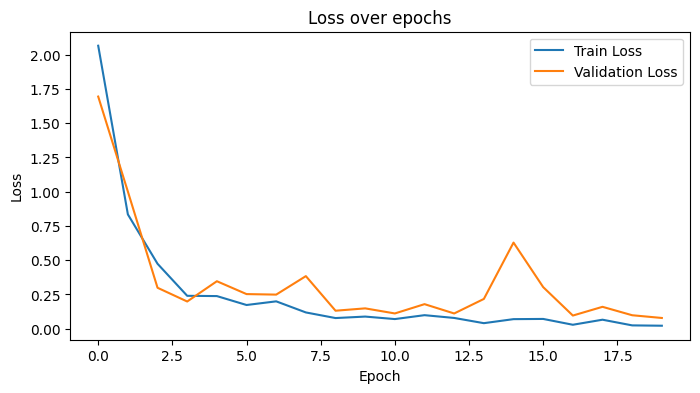

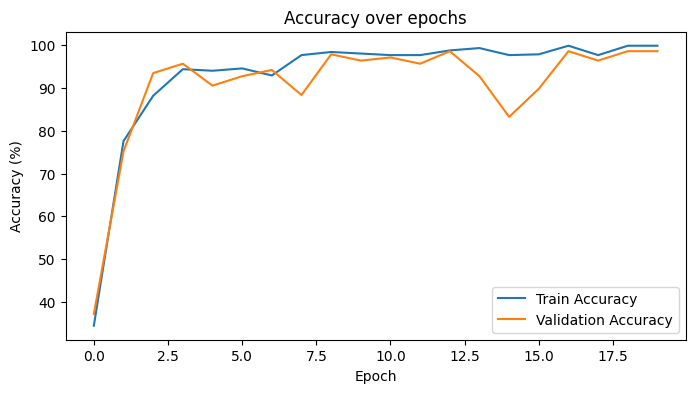

In [39]:
import torch.optim as optim

# Define model
model = LipReading3DCNN(num_classes=len(dataset.label_encoder.classes_)).to(device)

# Train and get history
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=20,
    learning_rate=0.001
)

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(8, 4))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


STEP 7 — Predict a single folder sample

In [40]:
def predict_single_video(folder_path, model, label_encoder, transform, max_frames=20):
    model.eval()
    frame_files = [f for f in os.listdir(folder_path) if f.endswith((".png", ".jpg"))]
    frame_files = sorted(frame_files, key=lambda x: int(os.path.splitext(x)[0]))

    total_frames = len(frame_files)
    if total_frames >= max_frames:
        indices = np.linspace(0, total_frames - 1, num=max_frames, dtype=int)
    else:
        indices = np.concatenate([
            np.arange(total_frames),
            np.full((max_frames - total_frames,), total_frames - 1)
        ])

    selected_frames = [frame_files[i] for i in indices]
    frames = []
    for frame_file in selected_frames:
        img_path = os.path.join(folder_path, frame_file)
        img = Image.open(img_path).convert("RGB")
        if transform:
            img = transform(img)
        frames.append(img)

    frames_tensor = torch.stack(frames, dim=0).unsqueeze(0).to(device)  # Add batch dim

    with torch.no_grad():
        outputs = model(frames_tensor)
        _, predicted = outputs.max(1)
        predicted_class = label_encoder.inverse_transform(predicted.cpu().numpy())[0]

    return predicted_class


In [41]:
# Example usage
test_folder = "dataset/cat_4" 
predicted_word = predict_single_video(
    folder_path=test_folder,
    model=model,
    label_encoder=dataset.label_encoder,
    transform=frame_transform,
    max_frames=20
)

print(f"Predicted word: {predicted_word}")


Predicted word: cat


 STEP 8 — Save + Load Model

In [42]:
# Save model to file
MODEL_PATH = "C:/Users/91951/Desktop/lip_reading_DNN/lip_reading_3dcnn.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Model saved to C:/Users/91951/Desktop/lip_reading_DNN/lip_reading_3dcnn.pth


In [43]:
# Load model from file
model_loaded = LipReading3DCNN(num_classes=len(dataset.label_encoder.classes_))
model_loaded.load_state_dict(torch.load(MODEL_PATH))
model_loaded = model_loaded.to(device)
model_loaded.eval()
print("Model loaded and ready for prediction")


Model loaded and ready for prediction


In [44]:
predicted_word = predict_single_video(
    folder_path="dataset/you_1",
    model=model_loaded,
    label_encoder=dataset.label_encoder,
    transform=frame_transform,
    max_frames=20
)
print(f"Predicted word: {predicted_word}")


Predicted word: you


STEP 9 — Generate confusion matrix

Final Validation Accuracy: 98.54%


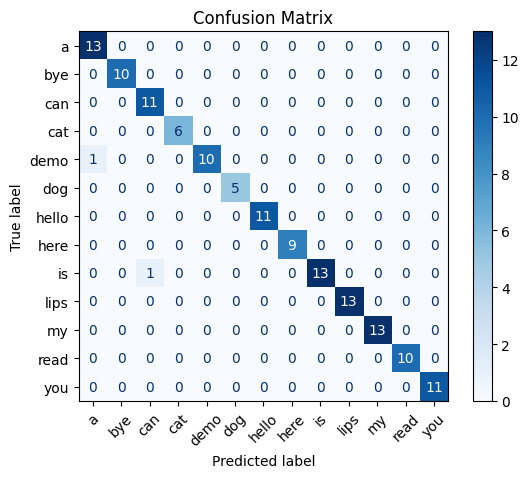

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader: 
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f"Final Validation Accuracy: {test_acc * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Dynamically get only the used class indices
used_classes = sorted(list(set(all_labels + all_preds)))

# Decode label indices to actual class names
display_names = dataset.label_encoder.inverse_transform(used_classes)

# Display the confusion matrix safely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
